#### This module test how patches size influence the PSNR

Use net structure: ESPCN
Hyper parameters:
- Learning rate decay: 0.9 for each iteration
- start learning rate: 0.01
- second part learning rate = learning rate * 0.01
- criterion: MSELoss
- optimizer: Adam

In [13]:
import os
import torch
import data_loader
from criteria import PSNR, SSIM, show_img_in_loader_and_comparison, test_psnr_ssim_interpolation
from ESPCN_model import get_ESPCN_model, ESPCN_train, test_one_picture_in_val_set
from plot import show_img
import numpy as np
import matplotlib.pyplot as plt
import cv2
from tqdm import tqdm

In [3]:
base_path = r"D:\programming\dataset\DIV2K"
valid_hr = os.path.join(base_path, "DIV2K_valid_HR")
valid_lr = os.path.join(base_path, "DIV2K_valid_LR_bicubic_X2")

#### test PSNR and SSIM using interpolation

In [41]:
def PSNR_SSIM_interpolation():
    h5_train_path = os.path.join(base_path, "train_BGR_channel")
    train_dataloader, val_dataloader = data_loader.create_train_val_data_loader(
        h5_train_path, valid_hr, valid_lr, batch_size=1)
    psnr_list = list()
    ssim_list = list()
    with tqdm(total=250) as t:
        for hr, lr in val_dataloader:
            hr = np.squeeze(hr.numpy()) * 255
            hr_y = hr[:, :, 0]  # get Y channel of hr

            lr = (np.squeeze(lr.numpy()) * 255).astype(np.uint8)
            lr_y = lr[:, :, 0]  # get Y channel of lr
            lr_y = cv2.resize(lr_y, (hr.shape[1], hr.shape[0]), interpolation=cv2.INTER_CUBIC)
            lr_y = lr_y.astype(np.float32)
            
            psnr = PSNR(hr_y, lr_y, 255)
            psnr_list.append(psnr)
            ssim = SSIM(hr_y, lr_y)
            ssim_list.append(ssim)
            t.update(1)
    print("PSNR interpolation is: {:.4f}, std: {:.4f}, SSIM interpolation is: {:.4f}, std: {:.4f}".
          format(np.average(psnr_list), np.std(psnr_list), np.average(ssim_list), np.std(ssim_list)))
    
PSNR_SSIM_interpolation()

100%|████████████████████████████████████████████████████████████████████████████████| 250/250 [01:49<00:00,  2.28it/s]

PSNR interpolation is: 31.4287, std: 4.9404, SSIM interpolation is: 0.9017, std: 0.0601


#### train model


In [27]:
def script(h5_train_path, model_save_path, batch_size):
    h5_train_path = os.path.join(base_path, h5_train_path)
    model_save_path = os.path.join(base_path, model_save_path)

    train_dataloader, val_dataloader = data_loader.create_train_val_data_loader(
        h5_train_path, valid_hr, valid_lr, batch_size=batch_size)
    model, device, current_epoch, PSNR_list, SSIM_list = get_ESPCN_model(model_save_path=model_save_path)

    ESPCN_train(model, device, train_dataloader, val_dataloader,
                   current_epoch, PSNR_list, SSIM_list, model_save_path,
                   max_epoch=20)
    

In [28]:
script("train_Ychannel_size_256_512", "ESPCN_patch256_512_batch16.model", 16)
torch.cuda.empty_cache()
script("train_Ychannel_size_128_256", "ESPCN_patch128_256_batch16.model", 16)
torch.cuda.empty_cache()
script("train_Ychannel_size_64_128", "ESPCN_patch64_128_batch16.model", 16)
torch.cuda.empty_cache()
script("train_Ychannel_size_32_64", "ESPCN_patch32_64_batch16.model", 16)
torch.cuda.empty_cache()

script("train_Ychannel_size_128_256", "ESPCN_patch128_256_batch64.model", 64)
torch.cuda.empty_cache()
script("train_Ychannel_size_64_128", "ESPCN_patch64_128_batch256.model", 256)
torch.cuda.empty_cache()
script("train_Ychannel_size_32_64", "ESPCN_patch32_64_batch1024.model", 1024)
torch.cuda.empty_cache()

load model parameter
use device:  cuda:0


100%|██████████████████████████████████████████████████████████████████████████████| 8340/8340 [08:08<00:00, 17.07it/s]


init new model parameter
use device:  cuda:0


100%|████████████████████████████████████████████████████████████████████████████| 32500/32500 [55:52<00:00,  9.69it/s]


init new model parameter
use device:  cuda:0


100%|████████████████████████████████████████████████████████████████████████| 121280/121280 [1:15:57<00:00, 26.61it/s]


init new model parameter
use device:  cuda:0


100%|████████████████████████████████████████████████████████████████████████| 482360/482360 [9:00:13<00:00, 14.88it/s]


init new model parameter
use device:  cuda:0


100%|██████████████████████████████████████████████████████████████████████████████| 8120/8120 [56:19<00:00,  2.40it/s]


init new model parameter
use device:  cuda:0


100%|████████████████████████████████████████████████████████████████████████████| 7580/7580 [1:13:01<00:00,  1.73it/s]


init new model parameter
use device:  cuda:0


100%|████████████████████████████████████████████████████████████████████████████| 7520/7520 [2:16:56<00:00,  1.09s/it]


#### compare with same batch size, different patch size

In [35]:
def get_same_batch_diff_patch_PSNR_SSIM_list():
    model_name_dict = {
        "patch = 256":"ESPCN_patch256_512_batch16.model",
        "patch = 128":"ESPCN_patch128_256_batch16.model",
        "patch = 64":"ESPCN_patch64_128_batch16.model",
        "patch = 32":"ESPCN_patch32_64_batch16.model",
    }
    PSNR_training_process = dict()
    SSIM_training_process = dict()
    
    for model_name, save_path in model_name_dict.items():
        model_save_path = model_save_path = os.path.join(base_path, save_path)
        model, device, current_epoch, PSNR_list, SSIM_list = get_ESPCN_model(model_save_path=model_save_path)
        PSNR_training_process[model_name] = PSNR_list
        SSIM_training_process[model_name] = SSIM_list
    return PSNR_training_process, SSIM_training_process

def plot_same_batch_diff_patch(PSNR_training_process, SSIM_training_process):
    # plot for PSNR
    plt.figure(figsize=(10,8))
    plt.title("PSNR for different patches with batch size = 16")
    plt.xticks(np.linspace(1,20,20))
    plt.yticks(np.linspace(25,35,11))
    plt.ylabel("Average test PSNR(dB)")
    plt.xlabel("Number of epochs")
    plt.plot(range(1,21), np.ones(shape=(20,))*31.199, ':', label="BICUBIC(31.199dB)")
    for model_name in PSNR_training_process.keys():
        PSNR_list = np.asarray(PSNR_training_process[model_name])
        plt.plot(range(1,21), PSNR_list, label=model_name)
    plt.legend()
    plt.show()
    
    # plot for SSIM
    plt.figure(figsize=(10,8))
    plt.title("SSIM for different patches with batch size = 16")
    plt.xticks(np.linspace(1,20,20))
    plt.yticks(np.linspace(0.8, 0.95, 16))
    plt.ylabel("Average test SSIM")
    plt.xlabel("Number of epochs")
    plt.plot(range(1,21), np.ones(shape=(20,))* 0.901, ':', label="BICUBIC(0.901)")
    for model_name in SSIM_training_process.keys():
        SSIM_list = np.asarray(SSIM_training_process[model_name])
        plt.plot(range(1,21), SSIM_list, label=model_name)
    plt.legend()
    plt.show()
    
        
        

load model parameter
use device:  cuda:0
load model parameter
use device:  cuda:0
load model parameter
use device:  cuda:0
load model parameter
use device:  cuda:0


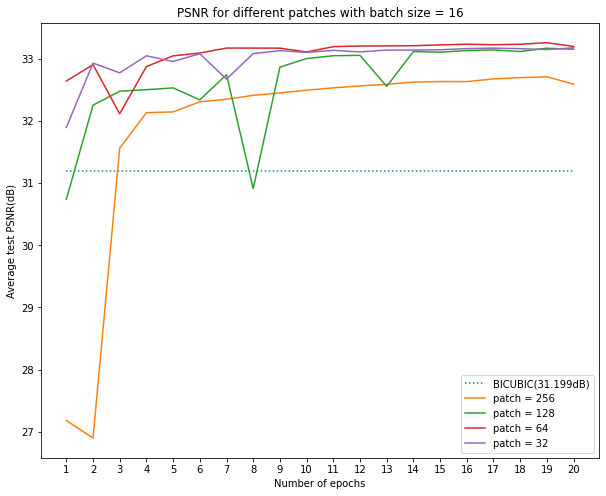

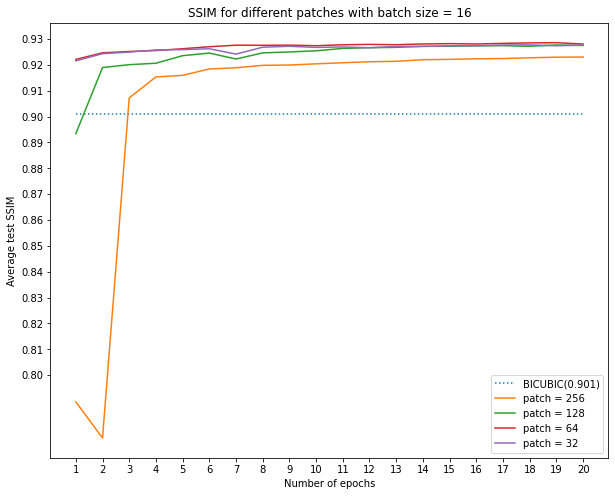

In [36]:
PSNR_training_process, SSIM_training_process = get_same_batch_diff_patch_PSNR_SSIM_list()
plot_same_batch_diff_patch(PSNR_training_process, SSIM_training_process)


#### compare with different batch size, different patch size, but same information

In [37]:
def get_same_info_diff_patch_PSNR_SSIM_list():
    model_name_dict = {
        "patch = 256, batch = 16":"ESPCN_patch256_512_batch16.model",
        "patch = 128, batch = 64":"ESPCN_patch128_256_batch64.model",
        "patch = 64, batch = 256":"ESPCN_patch64_128_batch256.model",
        "patch = 32, batch = 1024":"ESPCN_patch32_64_batch1024.model",
    }
    PSNR_training_process = dict()
    SSIM_training_process = dict()
    
    for model_name, save_path in model_name_dict.items():
        model_save_path = model_save_path = os.path.join(base_path, save_path)
        model, device, current_epoch, PSNR_list, SSIM_list = get_ESPCN_model(model_save_path=model_save_path)
        PSNR_training_process[model_name] = PSNR_list
        SSIM_training_process[model_name] = SSIM_list
    return PSNR_training_process, SSIM_training_process

def plot_same_info_diff_patch(PSNR_training_process, SSIM_training_process):
    # plot for PSNR
    plt.figure(figsize=(10,8))
    plt.title("PSNR for different patches with same data input size")
    plt.xticks(np.linspace(1,20,20))
    plt.yticks(np.linspace(25,35,11))
    plt.ylabel("Average test PSNR(dB)")
    plt.xlabel("Number of epochs")
    plt.plot(range(1,21), np.ones(shape=(20,))*31.199, ':', label="BICUBIC(31.199dB)")
    for model_name in PSNR_training_process.keys():
        PSNR_list = np.asarray(PSNR_training_process[model_name])
        plt.plot(range(1,21), PSNR_list, label=model_name)
    plt.legend()
    plt.show()
    
    # plot for SSIM
    plt.figure(figsize=(10,8))
    plt.title("SSIM for different patches with same data input size")
    plt.xticks(np.linspace(1,20,20))
    plt.yticks(np.linspace(0.8, 0.95, 16))
    plt.ylabel("Average test SSIM")
    plt.xlabel("Number of epochs")
    plt.plot(range(1,21), np.ones(shape=(20,))* 0.901, ':', label="BICUBIC(0.901)")
    for model_name in SSIM_training_process.keys():
        SSIM_list = np.asarray(SSIM_training_process[model_name])
        plt.plot(range(1,21), SSIM_list, label=model_name)
    plt.legend()
    plt.show()
    

load model parameter
use device:  cuda:0
load model parameter
use device:  cuda:0
load model parameter
use device:  cuda:0
load model parameter
use device:  cuda:0


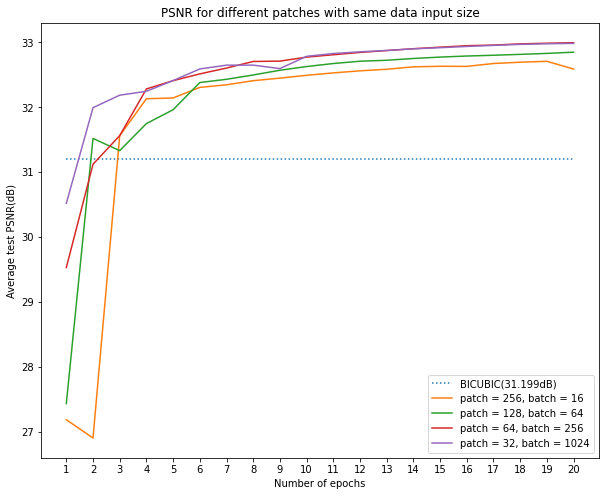

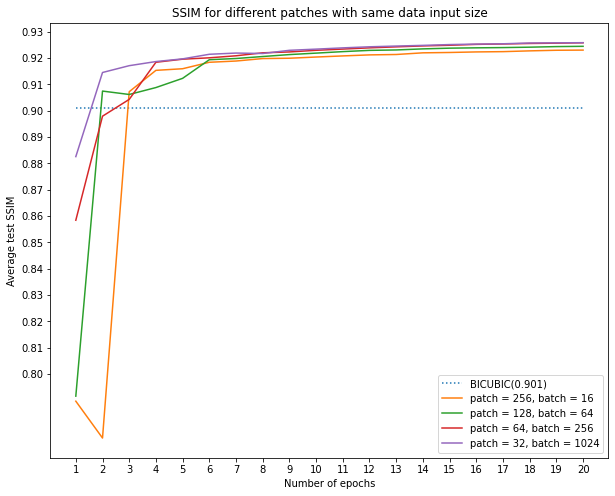

In [38]:
PSNR_training_process, SSIM_training_process = get_same_info_diff_patch_PSNR_SSIM_list()
plot_same_info_diff_patch(PSNR_training_process, SSIM_training_process)

#### compare with all

In [145]:
def get_all_PSNR_SSIM_list():
    model_name_dict = {
        "patch = 128, batch = 16":"ESPCN_patch128_256_batch16.model",
        "patch = 64, batch = 16":"ESPCN_patch64_128_batch16.model",
        "patch = 32, batch = 16":"ESPCN_patch32_64_batch16.model",
        "patch = 256, batch = 16":"ESPCN_patch256_512_batch16.model",
        "patch = 128, batch = 64":"ESPCN_patch128_256_batch64.model",
        "patch = 64, batch = 256":"ESPCN_patch64_128_batch256.model",
        "patch = 32, batch = 1024":"ESPCN_patch32_64_batch1024.model",
    }
    PSNR_training_process = dict()
    SSIM_training_process = dict()
    
    for model_name, save_path in model_name_dict.items():
        model_save_path = model_save_path = os.path.join(base_path, save_path)
        model, device, current_epoch, PSNR_list, SSIM_list = get_ESPCN_model(model_save_path=model_save_path)
        PSNR_training_process[model_name] = PSNR_list
        SSIM_training_process[model_name] = SSIM_list
    return PSNR_training_process, SSIM_training_process

def plot_all_patch(PSNR_training_process, SSIM_training_process):
    # plot for PSNR
    plt.figure(figsize=(10,8))
    plt.title("PSNR for all training models")
    plt.xticks(np.linspace(1,20,20))
    plt.yticks(np.linspace(25,35,11))
    plt.plot(range(1,21), np.ones(shape=(20,))*31.422, ':', label="BICUBIC")
    for model_name in PSNR_training_process.keys():
        PSNR_list = np.asarray(PSNR_training_process[model_name])
        plt.plot(range(1,21), PSNR_list, label=model_name)
    plt.legend()
    plt.show()
    
    # plot for SSIM
    plt.figure(figsize=(10,8))
    plt.title("SSIM for all training models")
    plt.xticks(np.linspace(1,20,20))
    plt.yticks(np.linspace(0.8, 0.95, 16))
    plt.plot(range(1,21), np.ones(shape=(20,))* 0.901, ':', label="BICUBIC")
    for model_name in SSIM_training_process.keys():
        SSIM_list = np.asarray(SSIM_training_process[model_name])
        plt.plot(range(1,21), SSIM_list, label=model_name)
    plt.legend()
    plt.show()
    

load model parameter
use device:  cuda:0
load model parameter
use device:  cuda:0
load model parameter
use device:  cuda:0
load model parameter
use device:  cuda:0
load model parameter
use device:  cuda:0
load model parameter
use device:  cuda:0
load model parameter
use device:  cuda:0


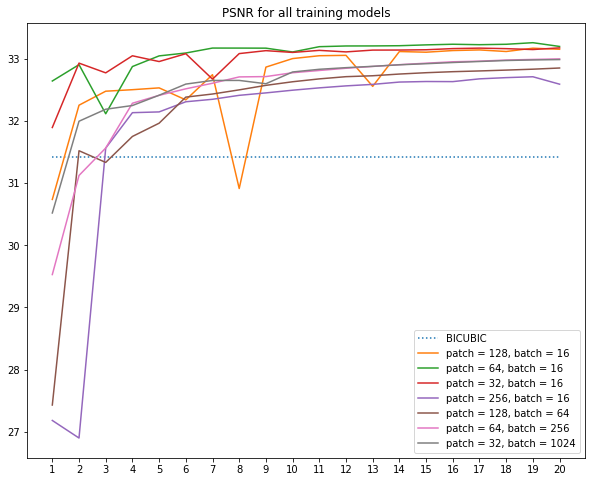

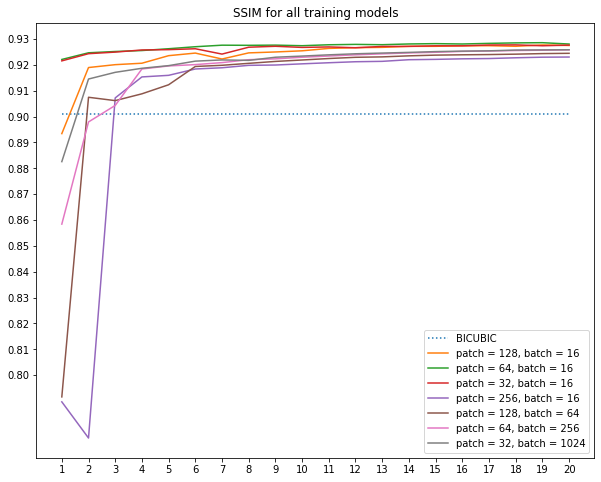

In [146]:
PSNR_training_process, SSIM_training_process = get_all_PSNR_SSIM_list()
plot_all_patch(PSNR_training_process, SSIM_training_process)

#### Calculate final PSNR and SSIM in validation set with standard deviation

In [23]:
from torch.utils.data import DataLoader

def test_psnr_ssim_with_std(model, device, val_dataloader):
    """
    test PSNR and SSIM for each epoch
    """
    psnr_list = list()
    ssim_list = list()
    padding = 6
    with tqdm(total=250) as t:
        for hr, lr in val_dataloader:
            hr = hr.numpy() * 255  # read hr from data loader
            hr = np.squeeze(hr)  # change shape to a image
            hr = hr[:, :, 0]  # get Y channel

            lr_y = lr[:, :, :, 0]  # get Y channel
            lr_y = torch.reshape(lr_y, (1, 1, lr.shape[1], lr.shape[2]))  # reshape Y channel that fit the input
            lr_y = lr_y.to(device)  # put into model
            lr_y = model(lr_y)
            lr_y = lr_y.cpu().data.numpy()  # get the model result
            lr_y = np.reshape(lr_y, newshape=(lr_y.shape[2], lr_y.shape[3]))  # reshape back to Y channel
            lr_y[lr_y > 1] = 1  # cut Y channel, 16<=Y<=235
            lr_y[lr_y < 0] = 0
            lr_y = lr_y * 255

            psnr = PSNR(lr_y, hr, 255)  # test the result for RSCNN
            psnr_list.append(psnr)
            ssim = SSIM(lr_y, hr)
            ssim_list.append(ssim)
            t.update(1)
            
    return np.average(psnr_list), np.std(psnr_list), np.average(ssim_list), np.std(ssim_list)


def test_model_PSNR_SSIM_with_std():
    model_name_dict = {
        "patch = 128, batch = 16":"ESPCN_patch128_256_batch16.model",
        "patch = 64, batch = 16":"ESPCN_patch64_128_batch16.model",
        "patch = 32, batch = 16":"ESPCN_patch32_64_batch16.model",
        "patch = 256, batch = 16":"ESPCN_patch256_512_batch16.model",
        "patch = 128, batch = 64":"ESPCN_patch128_256_batch64.model",
        "patch = 64, batch = 256":"ESPCN_patch64_128_batch256.model",
        "patch = 32, batch = 1024":"ESPCN_patch32_64_batch1024.model",
    }
    PSNR_training_process = dict()
    SSIM_training_process = dict()
    
    for model_name, save_path in model_name_dict.items():
        model_save_path = model_save_path = os.path.join(base_path, save_path)
        model, device, _, _, _ = get_ESPCN_model(model_save_path=model_save_path)
        
        ValDataset_ = data_loader.ValDataset(0, valid_hr, valid_lr)
        val_dataloader = DataLoader(dataset=ValDataset_, batch_size=1)
        psnr_ave, psnr_std, ssim_ave, ssim_std = test_psnr_ssim_with_std(model, device, val_dataloader)
        print("model name: {}, psnr_ave: {}, psnr_std: {}, ssim_ave: {}, ssim_std: {}".format(
            model_name, psnr_ave, psnr_std, ssim_ave, ssim_std))
        
test_model_PSNR_SSIM_with_std()

load model parameter
use device:  cuda:0


100%|████████████████████████████████████████████████████████████████████████████████| 250/250 [03:18<00:00,  1.26it/s]


model name: patch = 128, batch = 16, psnr_ave: 33.14955050235312, psnr_std: 5.073385200959934, ssim_ave: 0.9274806385523404, ssim_std: 0.04696112454692586
load model parameter
use device:  cuda:0


100%|████████████████████████████████████████████████████████████████████████████████| 250/250 [03:22<00:00,  1.23it/s]


model name: patch = 64, batch = 16, psnr_ave: 33.194908241224084, psnr_std: 5.067281577792513, ssim_ave: 0.9280343360261853, ssim_std: 0.04683186976554089
load model parameter
use device:  cuda:0


100%|████████████████████████████████████████████████████████████████████████████████| 250/250 [03:13<00:00,  1.29it/s]


model name: patch = 32, batch = 16, psnr_ave: 33.17245030651586, psnr_std: 5.063562109130683, ssim_ave: 0.9276092337162437, ssim_std: 0.046848138983775815
load model parameter
use device:  cuda:0


100%|████████████████████████████████████████████████████████████████████████████████| 250/250 [03:09<00:00,  1.32it/s]


model name: patch = 256, batch = 16, psnr_ave: 32.58829795937262, psnr_std: 4.899473235479341, ssim_ave: 0.9230068561155937, ssim_std: 0.04832467896216046
load model parameter
use device:  cuda:0


100%|████████████████████████████████████████████████████████████████████████████████| 250/250 [03:14<00:00,  1.28it/s]


model name: patch = 128, batch = 64, psnr_ave: 32.84836778916586, psnr_std: 5.0599285293611835, ssim_ave: 0.9244459740985341, ssim_std: 0.04789363712611304
load model parameter
use device:  cuda:0


100%|████████████████████████████████████████████████████████████████████████████████| 250/250 [03:14<00:00,  1.28it/s]


model name: patch = 64, batch = 256, psnr_ave: 32.99480429882107, psnr_std: 5.070905035523126, ssim_ave: 0.9257911675509957, ssim_std: 0.04755840629557442
load model parameter
use device:  cuda:0


100%|████████████████████████████████████████████████████████████████████████████████| 250/250 [03:12<00:00,  1.30it/s]

model name: patch = 32, batch = 1024, psnr_ave: 32.98400974433911, psnr_std: 5.0715186528813865, ssim_ave: 0.9258228132002067, ssim_std: 0.04768389550705308
